In [45]:
import numpy as np 
import scipy as sp
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import scipy.stats as sps
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from numba import njit
%matplotlib nbagg

# Второй эксперимент

In [257]:
TIME = 4
DELTA_T = 0.01
N_TIME = int(TIME/DELTA_T) + 1
H = 0.05
XRGE1 = 2
XRGE2 = 2
c1 = 1
c2 = 2
Z1 = 1
Z2 = 1.2
N_X1 = int(XRGE1/H) + 1
N_X2 = int(XRGE1/H) + 1
m = 2

Xs_ghost_1 = np.hstack((np.hstack((np.array([-2*H, -H]), np.linspace(0, XRGE1, N_X1))), np.array([XRGE1+H, XRGE1+2*H]))) 
Xs_ghost_2 = np.hstack((np.hstack((np.array([-2*H, -H]), np.linspace(0, XRGE2, N_X2))), np.array([XRGE2+H, XRGE2+2*H])))

In [258]:

def p_start(x):
    return 0


def p_left_boundary(t):
    if t <= 0:
        return 0
    f = 1
    return np.sin(2*np.pi*f * t)**2



def p_right_boundary(t):
    return 0

w_minus_1 = np.empty(shape=(N_TIME, N_X1 + 2*m))
w_plus_1 = np.empty(shape=(N_TIME, N_X1 + 2*m))
w_minus_2 = np.empty(shape=(N_TIME, N_X2 + 2*m))
w_plus_2 = np.empty(shape=(N_TIME, N_X2 + 2*m))

w_minus_1[0][m:-m] = 0 
w_plus_1[0][m:-m] = 0
w_minus_2[0][m:-m] = 0 
w_plus_2[0][m:-m] = 0

#ghost узлы по краям

w_minus_1[0][0], w_minus_1[0][1] = w_plus_1[0][2*m] - p_left_boundary(0 - 2*H/c1),\
                                    w_plus_1[0][1+m] - p_left_boundary(0 - 1*H/c1)
w_plus_1[0][0], w_plus_1[0][1] = w_minus_1[0][2*m] + p_left_boundary(0 + 2*H/c1),\
                                    w_minus_1[0][1+m] + p_left_boundary(0 + 1*H/c1)

w_minus_2[0][-1], w_minus_2[0][-2] = w_plus_2[0][-1-2*m] - p_right_boundary(0 + 2*H/c2),\
                                        w_plus_2[0][-2-m] - p_right_boundary(0 + 1*H/c2)
w_plus_2[0][-1], w_plus_2[0][-2] =  w_minus_2[0][-1-2*m] + p_right_boundary(0 - 2*H/c2),\
                                        w_minus_2[0][-2-m] + p_right_boundary(0 - 1*H/c2)

#ghost узлы на контакте(середине)
#Сначала найдем давления по новым формулам

def p_a(w_a_plus, w_a_minus, w_b_plus, w_b_minus, time, k):
    C = 2*Z1*Z2/(Z1+Z2)
    if k > 0:
        poly = np.polynomial.Polynomial(
                sp.interpolate.lagrange(Xs_ghost_2[m:m+5], w_b_minus[time][m:m+5]).coef[::-1]
                )
        return C * (w_a_plus[time][-1-m-k] - poly(Xs_ghost_2[m] + c2/c1*k*H))
    else:
        poly = np.polynomial.Polynomial(
                sp.interpolate.lagrange(Xs_ghost_2[m:m+5], w_b_plus[time][m:m+5]).coef[::-1]
                )
        return C * (-w_a_minus[time][-1-m+k] + poly(Xs_ghost_2[m] - c2/c1*k*H))

   
def p_b(w_a_plus, w_a_minus, w_b_plus, w_b_minus, time, k):
    C = 2*Z1*Z2/(Z1+Z2)
    if k > 0:
        poly = np.polynomial.Polynomial(
                sp.interpolate.lagrange(Xs_ghost_1[-1-m:-6-m:-1], w_a_plus[time][-1-m:-6-m:-1]).coef[::-1]
                )
        return C * (-w_b_minus[time][m+k] + poly(Xs_ghost_1[-1-m] - c1/c2*k*H))
    else:
        poly = np.polynomial.Polynomial(
                sp.interpolate.lagrange(Xs_ghost_1[-1-m:-6-m:-1], w_a_minus[time][-1-m:-6-m:-1]).coef[::-1]
                )
        return C * (w_b_plus[time][m-k] - poly(Xs_ghost_1[-1-m] + c1/c2*k*H))
        
#теперь заполним ghost узлы
w_minus_1[0][-1], w_minus_1[0][-2] = w_plus_1[0][1-2*m] - p_a(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=0, k=2),\
                                    w_plus_1[0][-2-m] - p_a(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=0, k=1)
w_plus_1[0][-1], w_plus_1[0][-2] =  w_minus_1[0][-1-2*m] + p_a(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=0, k=-2),\
                                    w_minus_1[0][-2-m] + p_a(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=0, k=-1)

w_minus_2[0][0], w_minus_2[0][1] = w_plus_2[0][2*m] - p_b(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=0, k=-2),\
                                    w_plus_2[0][1+m] - p_b(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=0, k=-1)
w_plus_2[0][0], w_plus_2[0][1] = w_minus_2[0][2*m] + p_b(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=0, k=2),\
                                    w_minus_2[0][1+m] + p_b(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=0, k=1)

In [259]:
#основной цикл
for i in tqdm(range(1, N_TIME)):
    #левая часть
    for j in range(m, N_X1 + m):
        #интерполяция
        interp_minus = sp.interpolate.lagrange(Xs_ghost_1[j-m:j+m+1], w_minus_1[i-1][j-m:j+m+1])
        interp_plus = sp.interpolate.lagrange(Xs_ghost_1[j-m:j+m+1], w_plus_1[i-1][j-m:j+m+1])
        poly_minus = np.polynomial.Polynomial(interp_minus.coef[::-1])
        poly_plus = np.polynomial.Polynomial(interp_plus.coef[::-1])
        #заполнение узлов
        w_minus_1[i][j] = poly_minus(Xs_ghost_1[j] + c1*DELTA_T)
        w_plus_1[i][j] = poly_plus(Xs_ghost_1[j] - c1*DELTA_T)
    #правая часть
    for j in range(m, N_X2 + m):
        #интерполяция
        interp_minus = sp.interpolate.lagrange(Xs_ghost_2[j-m:j+m+1], w_minus_2[i-1][j-m:j+m+1])
        interp_plus = sp.interpolate.lagrange(Xs_ghost_2[j-m:j+m+1], w_plus_2[i-1][j-m:j+m+1])
        poly_minus = np.polynomial.Polynomial(interp_minus.coef[::-1])
        poly_plus = np.polynomial.Polynomial(interp_plus.coef[::-1])
        #заполнение узлов
        w_minus_2[i][j] = poly_minus(Xs_ghost_2[j] + c2*DELTA_T)
        w_plus_2[i][j] = poly_plus(Xs_ghost_2[j] - c2*DELTA_T)  

    #заполнение gost узлов
    w_minus_1[i][0], w_minus_1[i][1] = w_plus_1[i][2*m] - p_left_boundary(i*DELTA_T - 2*H/c1), \
                                    w_plus_1[i][1+m] - p_left_boundary(i*DELTA_T - 1*H/c1)
    w_plus_1[i][0], w_plus_1[i][1] = w_minus_1[i][2*m] + p_left_boundary(i*DELTA_T + 2*H/c1),\
                                    w_minus_1[i][1+m] + p_left_boundary(i*DELTA_T + 1*H/c1)
    w_minus_2[i][-1], w_minus_2[i][-2] = w_plus_2[i][-1-2*m] - p_right_boundary(0 + 2*H/c2),\
                                        w_plus_2[i][-2-m] - p_right_boundary(0 + 1*H/c2)
    w_plus_2[i][-1], w_plus_2[i][-2] =  w_minus_2[i][-1-2*m] + p_right_boundary(0 - 2*H/c2),\
                                        w_minus_2[i][-2-m] + p_right_boundary(0 - 1*H/c2)


    w_minus_1[i][-1], w_minus_1[i][-2] = w_plus_1[i][-1-2*m] - p_a(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=i, k=2),\
                                        w_plus_1[i][-2-m] - p_a(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=i, k=1)
    w_plus_1[i][-1], w_plus_1[i][-2] =  w_minus_1[i][-1-2*m] + p_a(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=i, k=-2),\
                                        w_minus_1[i][-2-m] + p_a(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=i, k=-1)
    w_minus_2[i][0], w_minus_2[i][1] = w_plus_2[i][2*m] - p_b(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=i, k=-2),\
                                    w_plus_2[i][1+m] - p_b(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=i, k=-1)
    w_plus_2[i][0], w_plus_2[i][1] = w_minus_2[i][2*m] + p_b(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=i, k=2),\
                                    w_minus_2[i][1+m] + p_b(w_plus_1, w_minus_1, w_plus_2, w_minus_2, time=i, k=1)


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:02<00:00,  6.40it/s]


<IPython.core.display.Javascript object>


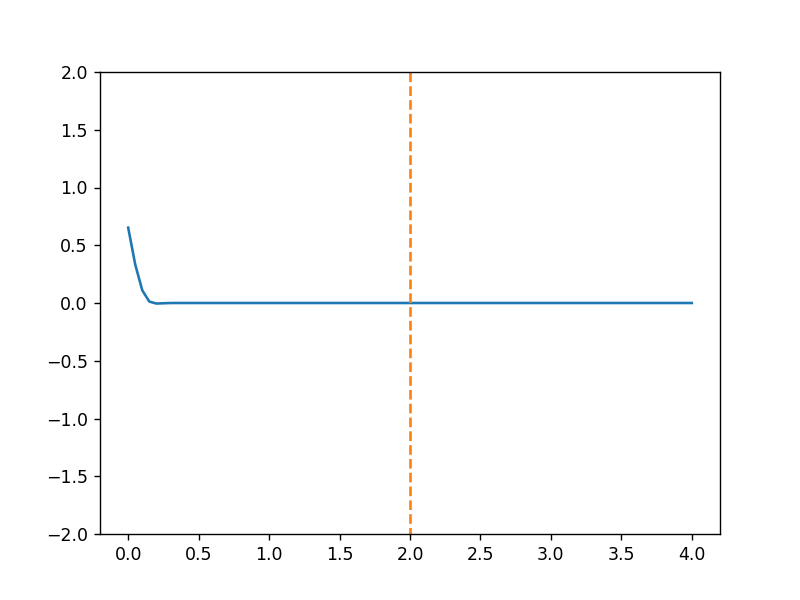

In [264]:
#визуализация
solution = np.hstack((w_plus_1[:, m:-m] - w_minus_1[:, m:-m], w_plus_2[:, m:-m] - w_minus_2[:, m:-m]))
Xs = np.hstack((Xs_ghost_1[m:-m], Xs_ghost_2[m:-m] + XRGE1))

fig = plt.figure()
ax = plt.axes()

def animate(i):
    ax.clear()
    ax.plot(Xs, solution[i])
    ax.set_ylim(-2, 2)
    ax.plot([2, 2], [2, -2], '--')
    
ani = FuncAnimation(fig, animate, frames=400, interval=20, blit=True)

In [266]:
from matplotlib.animation import PillowWriter
writer = PillowWriter(fps=10)
ani.save("second.gif", writer=writer)